In [33]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io


class CatsAndDogsDataset(Dataset):
  def __init__(self,csv_file,root,transform=None):
    self.annotations=pd.read_csv(csv_file)
    self.root=root
    self.transform=transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=os.path.join(self.root,self.annotations.iloc[index,0]) # annotations is a csv file, take the indexed index and col 0 from that csv file
    image=io.imread(img_path)
    y_label=torch.tensor(int(self.annotations.iloc[index,1]))

    
    if(self.transform):
      
      image=self.transform(image)

    
    return (image,y_label)

  

    


In [3]:
#importing


import torch
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F # activation functions.....etc
from torch.utils.data import DataLoader # easier dataset management
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torchvision


In [3]:
import os
now=os.getcwd()
print(now)
print("-----------")
os.chdir("/content/drive")
now=os.getcwd()
print(now)
print("----------")
files=os.listdir()
for file in files:
  print(os.path.join(now,file)) 

/content
-----------
/content/drive
----------
/content/drive/MyDrive
/content/drive/Shareddrives
/content/drive/Othercomputers
/content/drive/.shortcut-targets-by-id
/content/drive/.file-revisions-by-id
/content/drive/.Trash-0


In [4]:
#set device

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#hyperparameters

in_channel=3
num_classes=2
lr=0.001
batch_size=32
num_epochs=10

In [6]:
#getting the data

In [37]:
data_transform_train = transforms.Compose([
                                        
                                        transforms.ToTensor(),
                                        transforms.Resize((400,400))]
                                       )



dataset=CatsAndDogsDataset(csv_file='/content/drive/MyDrive/Pytorch Tutorial/Datasets/catsAnddogs2.csv',root='/content/drive/MyDrive/Pytorch Tutorial/Datasets/New folder'
,transform=data_transform_train)

torch.Size([400, 400, 3])


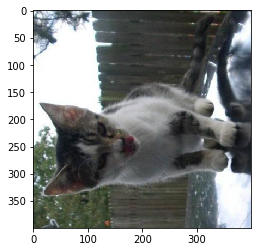

In [39]:
x,y=dataset.__getitem__(4)
x=x.swapaxes(0,2)
print(x.shape)
import matplotlib.pyplot as plt

plt.imshow(x,interpolation='nearest')
plt.show()

In [40]:
train_set, test_set = torch.utils.data.random_split(dataset, [170, 31])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [47]:
class CNN(nn.Module):
  def __init__(self,in_channel=3,num_classes=2):
    super(CNN,self).__init__()

    self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    self.pool=nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)) # we will use this layer twice, need to define just once
    self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
    self.fc1=nn.Linear(16*100*100,1000)
    self.fc2=nn.Linear(1000,100)
    self.fc3=nn.Linear(100,num_classes)

  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=self.pool(x)
    x=F.relu(self.conv2(x))
    x=self.pool(x)
    x=x.reshape(x.shape[0],-1)
    x=self.fc1(x)
    x=self.fc2(x)
    x=self.fc3(x)


    return x

In [49]:
model=CNN()
model.to(device)
loss_function=nn.CrossEntropyLoss()
opt=optim.Adam(model.parameters(),lr=lr)




num_epochs=25
for epoch in range(num_epochs):
  losses=[]

  for batch_idx,(data,target) in enumerate(train_loader):
    data=data.to(device=device)
    targets=target.to(device=device)

    scores=model(data)
    loss=loss_function(scores,targets)

    losses.append(loss)

    opt.zero_grad()
    loss.backward()

    opt.step()

  mean_loss=sum(losses)/len(losses)
  print("Loss at epoch: "+str(epoch)+ " is: "+str(mean_loss))




Loss at epoch: 0 is: tensor(43.3146, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 1 is: tensor(38.4594, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 2 is: tensor(7.3885, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 3 is: tensor(10.4964, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 4 is: tensor(1.1629, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 5 is: tensor(0.8235, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 6 is: tensor(0.7073, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 7 is: tensor(0.7015, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 8 is: tensor(0.6947, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 9 is: tensor(0.6753, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 10 is: tensor(0.6336, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 11 is: tensor(0.5905, device='cuda:0', grad_fn=<DivBackward0>)
Loss at epoch: 12 is: tensor(0.5818, device='cuda:0', grad_fn=<DivBackw

In [50]:
#check accuracy 

def accuracy_check(loader,model): # get the dataset(loader here), and trained model

 

  num_correct=0
  num_samples=0

  model.eval()

  with torch.no_grad(): # no need to train now
    for x,y in loader:
      x=x.to(device=device).squeeze(1)
      y=y.to(device=device)

      #x=x.reshape(x.shape[0],-1)
      scores=model(x)
      #64 X 10

      _,predictions=scores.max(1) # get the max index of each ROW
      num_correct+=(predictions==y).sum() # here in each iteration of the loop, a batch of size 64 will be passed here. In each batch ,
                                          #we have 64 data. We sum all these 64 data predictions ( 1 or 0)
      num_samples+=predictions.size(0)

    acc=num_correct/num_samples*100
    print(acc)

    

In [52]:
accuracy_check(train_loader, model)
accuracy_check(test_loader, model)

tensor(100., device='cuda:0')
tensor(58.0645, device='cuda:0')
